In [1]:
import numpy as np
import pandas as pd
import glob
from math import sqrt
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#parameter
# NoVlaueCols = [ 'LE', 'LE_QC', 'SH', 'SH_QC', 'GPP', 'GPP_QC', 'NEE','NEE_QC']
UseCols = ['DateTime', 'isNight', 'TA', 'RG', 'RLU', 'RN', 'U', 'VPD', 'PA', 'PR',
       'NDVI', 'EVI', 'GNDVI', 'LSWI', 'ALB_SW', 'ALB_NIR', 'USTAR',
       'USTAR_QC']

In [3]:
data_path = 'Site_Data/'

fps = glob.glob(data_path+'/*.csv')

fps = random.sample(fps, 20)

In [4]:
#读取训练集
data = None
for i,file in enumerate(fps):
    t = pd.read_csv(file,usecols = UseCols)
    if i == 0:
        data = t
    else:
        data = pd.concat([data, t], axis=0, join='outer', sort=False)
#     if i == 6:
#         break

In [6]:
def process_data(data):
    #传入dataframe不直接改变dataframe值
    qc = (data.loc[:,'USTAR_QC'] == 1)
    Exception_Cols = ['PA','RLU','EVI','GNDVI']
    tt = data.loc[:,Exception_Cols]
    Q1 = np.percentile(tt, 25,axis = 0)
    Q3 = np.percentile(tt,75,axis = 0)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    tt[(tt<Q1-outlier_step)|(tt>Q3+outlier_step)] = np.nan
    qc[np.any(np.isnan(tt.loc[:,Exception_Cols]),axis = 1)] = False
    data = data.loc[qc,:]
    return data
    
    
    
    

In [7]:
data = process_data(data)

<AxesSubplot:>

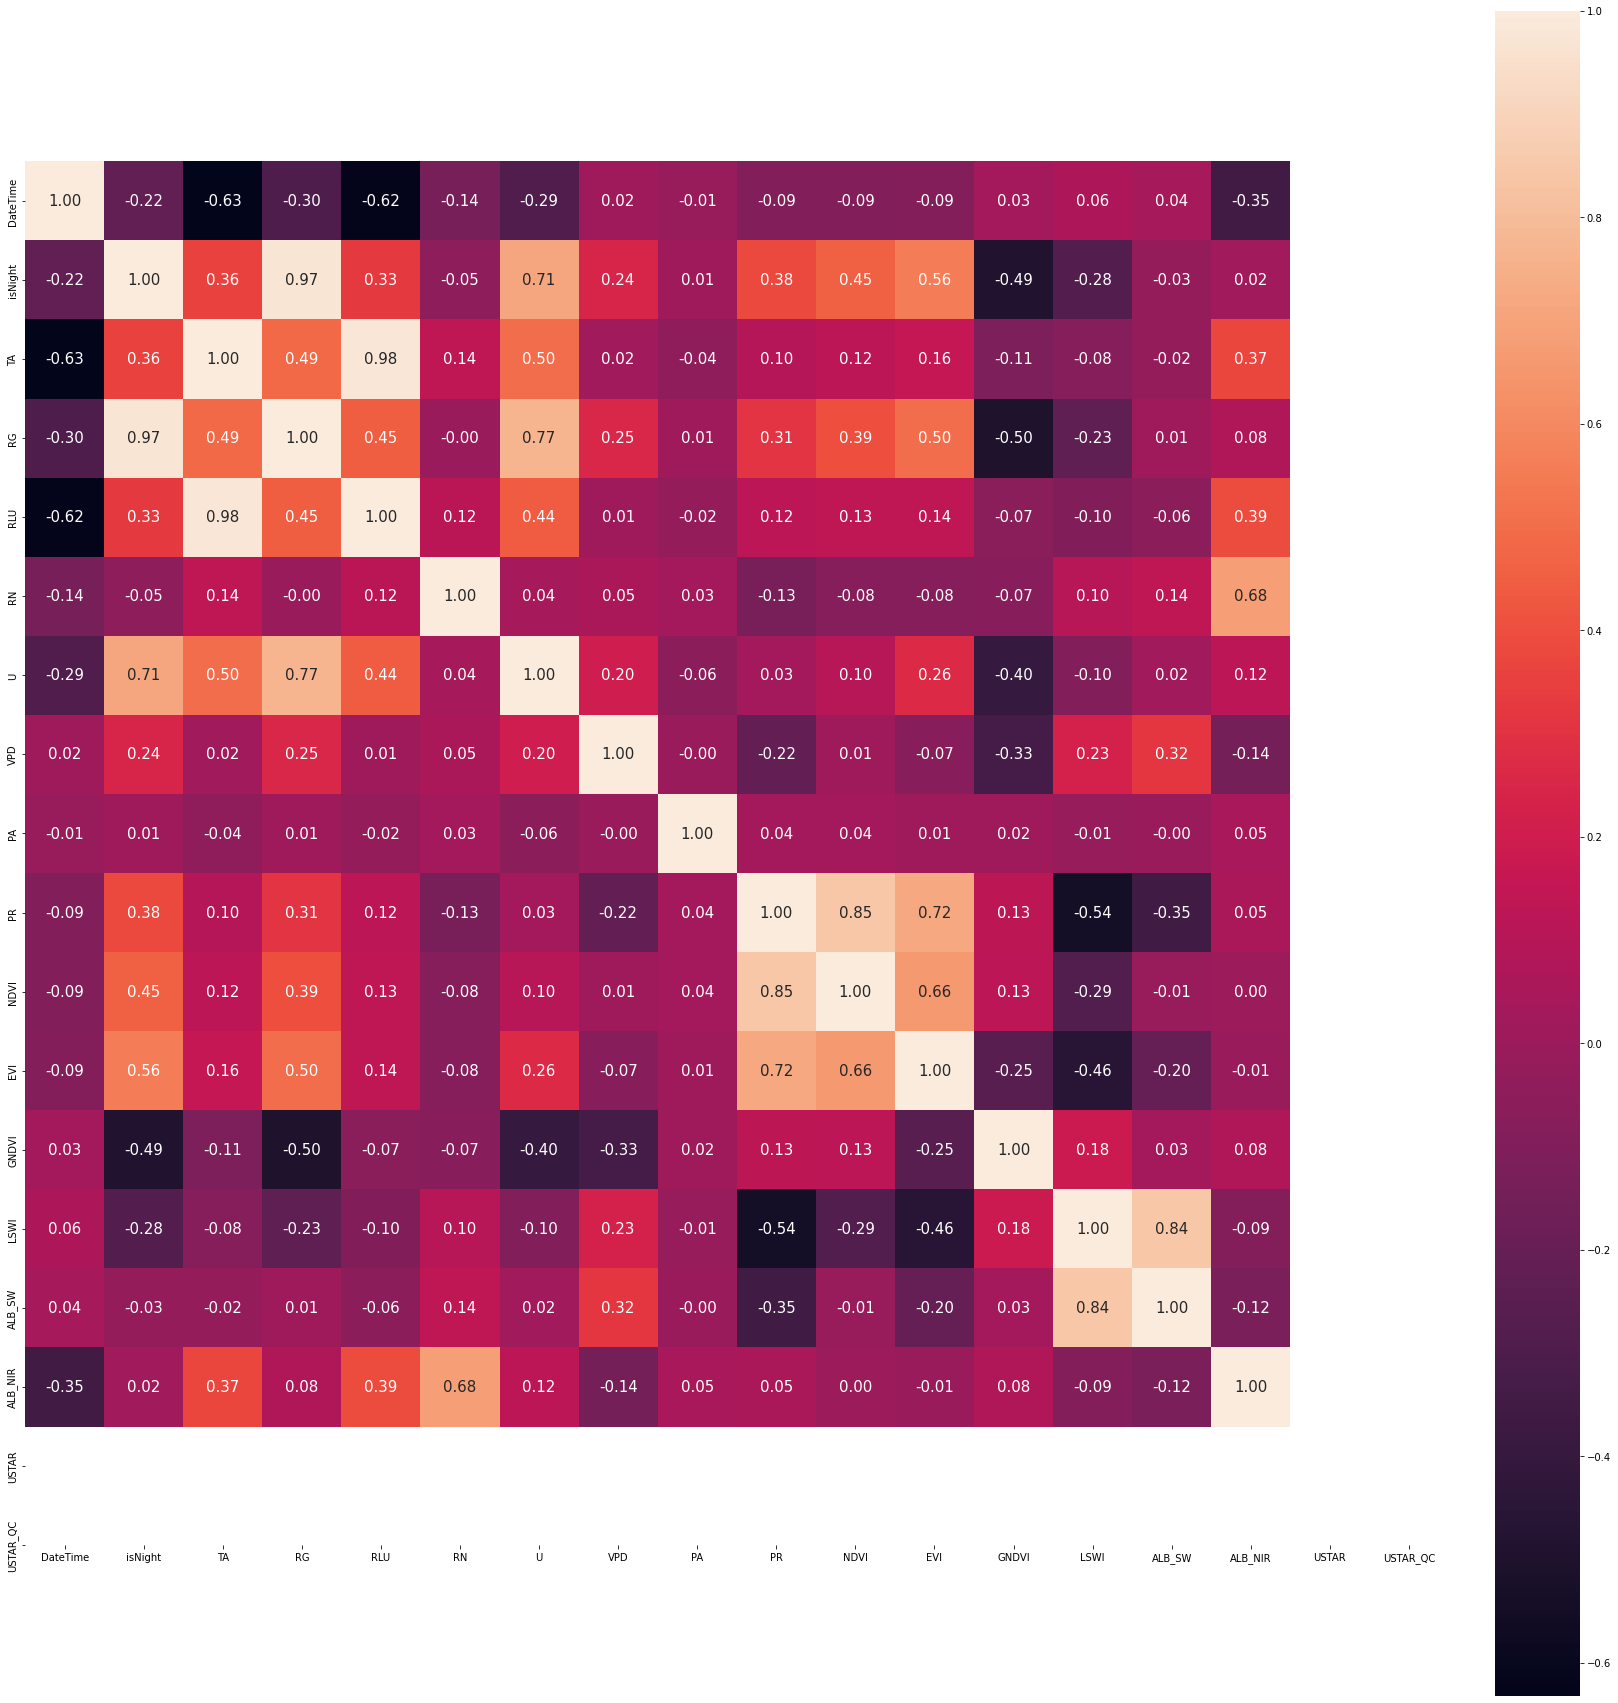

In [8]:
corr = data.corr()
plt.figure(figsize=(31,31))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data.columns, yticklabels= data.columns)

In [11]:
cols = [i for i in data.columns if i not in ['USTAR','USTAR_QC','DateTime']]
X = data[cols]
corr_matrix = X.corr().abs() 

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.85)]


In [12]:
to_drop

['TA', 'RG']

In [13]:
cols = [i for i in data.columns if i not in ['USTAR','USTAR_QC','DateTime','TA', 'RG']]

X = data[cols]
y = data['USTAR']

In [16]:
from sklearn.model_selection import train_test_split 
train_persentage = 0.6
#60%训练集 20%验证集 20%测试集 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-train_persentage, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp , test_size=0.5, random_state=2)

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 10)

## 模型预测

In [ ]:
# 评分函数

In [17]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [18]:
def model_score(model,X_train,y_train,y_test,y_pred):
    print('分数: ',model.score(X_train,y_train))
    error = sqrt(metrics.mean_squared_error(y_test,y_pred))
    print('均方根误差RMSE: ',error)

    print('均方误差MSE: {}'.format(
    round(metrics.mean_squared_error(y_test,y_pred),2)))

    print('解释方差分: {}'.format(
    round(metrics.explained_variance_score(y_test,y_pred),2)))

    print('R平方得分: {}'.format(
    round(metrics.r2_score(y_test,y_pred),2)))
    

### 数据归一化

In [19]:
from sklearn import preprocessing

In [20]:
# def Scaler(x):
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_valid = min_max_scaler.fit_transform(X_valid)


### LightGBM

In [21]:
import lightgbm as lgb

D:\Download\Anaconda\neirong\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
# LGBM初始参数
params = {    
          'objective' : 'regression',
          'metric': 'l1',
          'learning_rate':0.1,
          'num_leaves':60, #由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
          'max_depth': 6,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
    }

In [31]:
gbm = lgb.LGBMRegressor(**params)
# i = 1
# gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=200)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],early_stopping_rounds=50)
# eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds=30
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
# print('The MSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
# print('Feature importances:', list(gbm.feature_importances_))
model_score(gbm,X_train,y_train,y_valid,y_pred)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],early_stopping_rounds=50)

D:\Download\Anaconda\neirong\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l1: 0.206789
[2]	valid_0's l1: 0.193076
[3]	valid_0's l1: 0.181048
[4]	valid_0's l1: 0.170814
[5]	valid_0's l1: 0.161511
[6]	valid_0's l1: 0.159337
[7]	valid_0's l1: 0.151614
[8]	valid_0's l1: 0.144948
[9]	valid_0's l1: 0.139595
[10]	valid_0's l1: 0.134247
[11]	valid_0's l1: 0.133161
[12]	valid_0's l1: 0.128722
[13]	valid_0's l1: 0.12689
[14]	valid_0's l1: 0.123868
[15]	valid_0's l1: 0.120442
[16]	valid_0's l1: 0.118201
[17]	valid_0's l1: 0.117149
[18]	valid_0's l1: 0.114469
[19]	valid_0's l1: 0.112187
[20]	valid_0's l1: 0.110147
[21]	valid_0's l1: 0.10849
[22]	valid_0's l1: 0.107198
[23]	valid_0's l1: 0.106383
[24]	valid_0's l1: 0.106338
[25]	valid_0's l1: 0.10522
[26]	valid_0's l1: 0.104242
[27]	valid_0's l1: 0.103236
[28]	valid_0's l1: 0.102401
[29]	valid_0's l1: 0.101605
[30]	valid_0's l1: 0.101033
[31]	valid_0's l1: 0.100607
[32]	valid_0's l1: 0.100111
[33]	valid_0's l1: 0.0999222
[34]	valid_0's l1: 0.099535
[35]	valid_0's l1: 0.0992482
[36]	valid_0's l1: 0.0989874
[

In [ ]:
##模型调参

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
# params_test1={'max_depth': range(3,8,1), 'num_leaves':range(1, 100, 5)}
params_test1={ 'num_leaves':range(30, 120, 5)}
              
gsearch1 = GridSearchCV(estimator = gbm, 
                       param_grid = params_test1, scoring='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train,y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [48]:
gsearch1.best_score_

-0.011752888948478877

In [49]:
gsearch1.best_params_

{'num_leaves': 65}

In [50]:
gsearch1.cv_results_

{'mean_fit_time': array([2.57231255, 2.34583268, 2.62636738, 2.66792426, 3.00660019,
        2.52870078, 2.52169204, 2.53478804, 2.4286799 , 2.50912781,
        2.47360878, 2.48560915, 2.6244873 , 2.70545673, 2.58648047,
        2.61361551, 2.89881768, 2.60846362]),
 'std_fit_time': array([0.28291187, 0.05558599, 0.21613355, 0.29541195, 0.2059757 ,
        0.0782874 , 0.10272   , 0.09453116, 0.00816467, 0.03636489,
        0.05137319, 0.05936552, 0.11824747, 0.14890245, 0.14532644,
        0.10207431, 0.26385083, 0.07170695]),
 'mean_score_time': array([0.24351788, 0.26722851, 0.28875952, 0.29039221, 0.29759846,
        0.2812973 , 0.26722817, 0.27202845, 0.27645392, 0.2640276 ,
        0.26763215, 0.25941477, 0.27112203, 0.2810905 , 0.28484035,
        0.26464381, 0.2955914 , 0.26978388]),
 'std_score_time': array([0.01462934, 0.00391933, 0.01635535, 0.01775618, 0.02537894,
        0.01449725, 0.01723339, 0.03356436, 0.01980137, 0.02426773,
        0.01661179, 0.02207178, 0.01752494, 

In [ ]:
# params_test1={'max_depth': range(3,8,1), 'num_leaves':range(1, 100, 5)}
params_test1={num_leaves':range(1, 100, 5)}
              
gsearch1 = GridSearchCV(estimator = gbm, 
                       param_grid = params_test1, scoring='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train,y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [23]:
# 调参之后的参数
# LGBM初始参数
params = {    
          'objective' : 'regression',
          'metric': 'l1',
          'learning_rate':0.9,
          'num_leaves':620, 
          'max_depth': 11,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
    }

In [24]:
gbm = lgb.LGBMRegressor(**params)
# i = 1
# gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=200)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],early_stopping_rounds=50)
# eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds=30
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
# print('The MSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
# print('Feature importances:', list(gbm.feature_importances_))
model_score(gbm,X_train,y_train,y_valid,y_pred)

D:\Download\Anaconda\neirong\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l1: 0.186387
[2]	valid_0's l1: 0.110282
[3]	valid_0's l1: 0.104857
[4]	valid_0's l1: 0.102422
[5]	valid_0's l1: 0.100402
[6]	valid_0's l1: 0.0998082
[7]	valid_0's l1: 0.0982916
[8]	valid_0's l1: 0.0979511
[9]	valid_0's l1: 0.097713
[10]	valid_0's l1: 0.0971002
[11]	valid_0's l1: 0.0968878
[12]	valid_0's l1: 0.0967419
[13]	valid_0's l1: 0.0962935
[14]	valid_0's l1: 0.0961086
[15]	valid_0's l1: 0.0957281
[16]	valid_0's l1: 0.0954854
[17]	valid_0's l1: 0.0954235
[18]	valid_0's l1: 0.0952298
[19]	valid_0's l1: 0.0949618
[20]	valid_0's l1: 0.0947063
[21]	valid_0's l1: 0.0944871
[22]	valid_0's l1: 0.0943193
[23]	valid_0's l1: 0.0942665
[24]	valid_0's l1: 0.0940264
[25]	valid_0's l1: 0.0938825
[26]	valid_0's l1: 0.0938126
[27]	valid_0's l1: 0.0937475
[28]	valid_0's l1: 0.0936376
[29]	valid_0's l1: 0.0935027
[30]	valid_0's l1: 0.0932646
[31]	valid_0's l1: 0.0932306
[32]	valid_0's l1: 0.0932346
[33]	valid_0's l1: 0.0931267
[34]	valid_0's l1: 0.0931507
[35]	valid_0's l1: 0.093137
[

In [25]:
#测试集评分
y_pred = gbm.predict(X_test)
model_score(gbm,X_train,y_train,y_test,y_pred)

分数:  0.8792212273689926
均方根误差RMSE:  0.1247789226860464
均方误差MSE: 0.02
解释方差分: 0.81
R平方得分: 0.79


In [26]:
pkl_filename1 = "LGBM_model.pkl"

with open(pkl_filename1, 'wb') as file:
    pickle.dump(gbm, file)

### XGBRegression

In [27]:
import xgboost as xgb

In [28]:
#调参之后的参数2
other_params = {'eta': 0.3, 'n_estimators': 500, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}


In [29]:
# mdl = xgb.XGBRegressor(n_estimators = 100,max_depth = 5,colsample_bytree = 0.5,subsample = 0.5,
#                        learning_rate = 0.2)
mdl = xgb.XGBRegressor(**other_params)
mdl.fit(X_train,y_train)
y_pred = mdl.predict(X_valid)
model_score(mdl,X_train,y_train,y_valid,y_pred)

分数:  0.8688614657472953
均方根误差RMSE:  0.11275735918137349
均方误差MSE: 0.01
解释方差分: 0.84
R平方得分: 0.83


In [30]:
pkl_filename2 = "XGB_model.pkl"

with open(pkl_filename2, 'wb') as file:
    pickle.dump(mdl, file)

In [28]:
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)}
regress_model = xgb.XGBRegressor(**other_params)  # 注意这里的两个 * 号！
#verbose：日志冗长度，int：冗长度，0：不输出训练过程，1：偶尔输出，>1：对每个子模型都输出。
gs = GridSearchCV(regress_model, cv_params, verbose=2, refit=True,cv = 2)
# gs = GridSearchCV(regress_model, cv_params, verbose=2, refit=True, cv=5)
gs.fit(X, y)  # X为训练数据的特征值，y为训练数据的label
# 性能测评
print("参数的最佳取值：:", gs.best_params_)
print("最佳模型得分:", gs.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ...................................n_estimators=100; total time=  26.8s
[CV] END ...................................n_estimators=100; total time=  28.5s
[CV] END ...................................n_estimators=200; total time=  55.0s
[CV] END ...................................n_estimators=200; total time=  58.6s
[CV] END ...................................n_estimators=300; total time= 1.4min
[CV] END ...................................n_estimators=300; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.9min
[CV] END ...................................n_estimators=400; total time= 2.0min
[CV] END ...................................n_estimators=500; total time= 2.5min
[CV] END ...................................n_estimators=500; total time= 2.6min
[CV] END ...................................n_estimators=600; total time= 3.4min
[CV] END ...................................n_es

In [ ]:
#调参之后的参数1

In [51]:
other_params = {'eta': 0.3, 'n_estimators': 100, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}


In [52]:
# mdl = xgb.XGBRegressor(n_estimators = 100,max_depth = 5,colsample_bytree = 0.5,subsample = 0.5,
#                        learning_rate = 0.2)
mdl = xgb.XGBRegressor(**other_params)
mdl.fit(X_train,y_train)
y_pred = mdl.predict(X_valid)
model_score(mdl,X_train,y_train,y_valid,y_pred)

分数:  0.8445076575156014
均方根误差RMSE:  0.11221560043005765
均方误差MSE: 0.01
解释方差分: 0.84
R平方得分: 0.84


In [ ]:
# params_test1={'max_depth': range(3,8,1), 'num_leaves':range(1, 100, 5)}
params_test1={max_depth':range(5, , 5)}
              
gsearch1 = GridSearchCV(estimator = gbm, 
                       param_grid = params_test1, scoring='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train,y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
## 初始参数

In [50]:
mdl = xgb.XGBRegressor(n_estimators = 100,max_depth = 5,colsample_bytree = 0.5,subsample = 0.5,
                       learning_rate = 0.2)
mdl.fit(X_train,y_train)
y_pred = mdl.predict(X_valid)
model_score(mdl,X_train,y_train,y_valid,y_pred)

分数:  0.8163493467892976
均方根误差RMSE:  0.1205093362843903
均方误差MSE: 0.01
解释方差分: 0.81
R平方得分: 0.81


In [ ]:
#测试集评分

In [61]:
y_pred = mdl.predict(X_test)
model_score(mdl,X_train,y_train,y_test,y_pred)

分数:  0.8817426916501875
均方根误差RMSE:  0.11400770435458736
均方误差MSE: 0.01
解释方差分: 0.83
R平方得分: 0.83


### SVR

In [ ]:
# 尝试使用SVR，但是因为SVM适用于小数据集，在运行大数据集时，运行时间过长

In [58]:
from sklearn.svm import SVR

In [59]:
from tqdm import tqdm, trange

In [60]:
X_train = X_train[0:30000]
y_train = y_train[0:30000]
X_valid = X_valid[0:3000]
y_valid = y_valid[0:3000]



In [61]:
for k in tqdm(['linear','poly','rbf','sigmoid']):
    clf = SVR(kernel = k)
    clf.fit(X_train,y_train)
    confidence = clf.score(X_train,y_train)
    print(k,confidence)

 25%|█████████████████████                                                               | 1/4 [00:23<01:11, 23.72s/it]

linear 0.6225879330591624



 50%|██████████████████████████████████████████                                          | 2/4 [01:15<01:20, 40.08s/it]

poly 0.7163577004131787



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:13<00:48, 48.49s/it]

rbf 0.7412461683875393


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:37<00:00, 54.42s/it]

sigmoid -997793.1039135382


In [23]:
Svr = SVR(kernel = 'rbf',C = 1,gamma = 0.5)
Svr.fit(X_train,y_train)
y_pred = Svr.predict(X_test)
model_score(Svr,X_train,y_train,y_test,y_pred)

分数:  0.7239952013554911
均方根误差RMSE:  0.13559491075216445
均方误差MSE: 0.02
解释方差分: 0.73
R平方得分: 0.73


### 随机森林

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
regr = RandomForestRegressor(random_state=0)

In [56]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_valid)
model_score(regr,X_train,y_train,y_valid,y_pred)

KeyboardInterrupt: 

In [86]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
# forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(regr, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)
# grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [87]:
# grid_search.cv_results_.keys
#没有训练所以没有属性参数
grid_search.best_score_

-0.016353424357518246

In [89]:
# grid_search.best_params_
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [90]:
grid_search.cv_results_

{'mean_fit_time': array([0.11863079, 0.39849391, 1.25228519, 0.22544556, 0.78737669,
        2.10149674, 0.2890687 , 1.03183808, 2.96086769, 0.40969014,
        1.23127394, 3.6860281 , 0.19604516, 0.6275939 , 0.25706444,
        0.8457839 , 0.32747207, 1.07623878]),
 'std_fit_time': array([0.00185854, 0.0081    , 0.0487909 , 0.02202181, 0.10517115,
        0.18879897, 0.00210144, 0.0688891 , 0.08667869, 0.02522983,
        0.03732673, 0.20354016, 0.00389825, 0.00323442, 0.00345485,
        0.00519584, 0.00233033, 0.00837867]),
 'mean_score_time': array([0.00579662, 0.016401  , 0.04700913, 0.00640173, 0.02020569,
        0.05061598, 0.00539818, 0.01780109, 0.04601259, 0.00599995,
        0.01580534, 0.04520411, 0.00640421, 0.01880407, 0.00619688,
        0.01840587, 0.00600357, 0.01820397]),
 'std_score_time': array([3.97324155e-04, 1.02117736e-03, 2.52407970e-03, 1.85692296e-03,
        3.92006810e-03, 7.78585070e-03, 4.92555580e-04, 3.77295564e-03,
        2.27661892e-03, 6.32196984e-

In [ ]:
# 调参之后的参数

In [33]:
params = {    
          'max_features': 6,
          'n_estimators': 30,
          'random_state':0
    }

In [34]:
regr = RandomForestRegressor(**params)

In [35]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_valid)
model_score(regr,X_train,y_train,y_valid,y_pred)

分数:  0.9797834688951598
均方根误差RMSE:  0.11271766620004557
均方误差MSE: 0.01
解释方差分: 0.84
R平方得分: 0.83


In [36]:
#测试集评分
y_pred = regr.predict(X_test)
model_score(regr,X_train,y_train,y_test,y_pred)

分数:  0.9797834688951598
均方根误差RMSE:  0.11414963957079706
均方误差MSE: 0.01
解释方差分: 0.84
R平方得分: 0.83


In [4]:
# 保存模型
import joblib

In [38]:
pkl_filename3 = "Random_forest_model.pkl"

with open(pkl_filename3, 'wb') as file:
    joblib.dump(regr, file)

### 决策树


In [39]:
from sklearn import tree

In [40]:
dec_tree = tree.DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_valid)
model_score(dec_tree,X_train,y_train,y_valid,y_pred)

分数:  0.9999999667035475
均方根误差RMSE:  0.16256127101590692
均方误差MSE: 0.03
解释方差分: 0.66
R平方得分: 0.65


#### 测试集评分

In [41]:
y_pred = dec_tree.predict(X_test)
model_score(dec_tree,X_train,y_train,y_test,y_pred)

分数:  0.9999999667035475
均方根误差RMSE:  0.1640593140525407
均方误差MSE: 0.03
解释方差分: 0.66
R平方得分: 0.64


In [42]:
pkl_filename4 = "Decision_tree_model.pkl"

with open(pkl_filename4, 'wb') as file:
    pickle.dump(dec_tree, file)

## 绘制特征重要性

In [3]:
pkl_filename1 = "LGBM_model.pkl"
pkl_filename2 = "XGB_model.pkl"
pkl_filename3 = "Random_forest_model.pkl"
pkl_filename4 = "Decision_tree_model.pkl"


with open(pkl_filename1, 'rb') as file:
    LGBM_model = pickle.load(file)
    
with open(pkl_filename2, 'rb') as file:
    XGB_model = pickle.load(file)
    
# with open(pkl_filename3, 'rb') as file:
#     Random_forest_model = pickle.load(file)
    
with open(pkl_filename4, 'rb') as file:
    Decision_tree_model = pickle.load(file)

D:\Download\Anaconda\neirong\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
with open(pkl_filename3, 'rb') as file:
    Random_forest_model = joblib.load(file)

In [8]:
cols = ['isNight', 'RLU', 'RN', 'U', 'VPD', 'PA', 'PR',
       'NDVI', 'EVI', 'GNDVI', 'LSWI', 'ALB_SW', 'ALB_NIR']

In [20]:
def Calculate_contribution_rate(model):
    cols = ['isNight', 'RLU', 'RN', 'U', 'VPD', 'PA', 'PR',
       'NDVI', 'EVI', 'GNDVI', 'LSWI', 'ALB_SW', 'ALB_NIR']
    iptList = model.feature_importances_ # a list of the variable importances
# cols = [col for col in dt[1].columns if col not in['DateTime','G','G_QC']]

    plt.barh(cols,iptList,height = 0.8,color = 'b')
    plt.title('摩擦风速模拟各因子的贡献率',fontsize=13)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.xlabel('因子贡献率',fontsize=12); plt.ylabel('输入因子',fontsize=12)
    for i in range(len(cols)):
        plt.text(iptList[i]+0.01,cols[i],str(iptList[i]))
    # 可以改为百分比
# plt.xlim(0,0.6)
    plt.show()
    

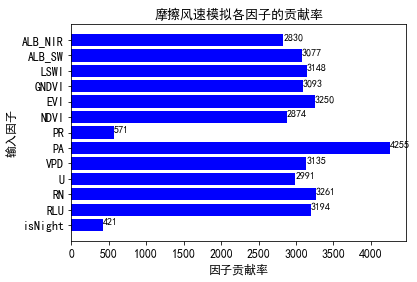

In [21]:
Calculate_contribution_rate(LGBM_model)

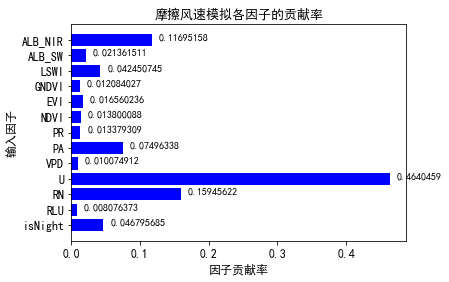

In [22]:
Calculate_contribution_rate(XGB_model)

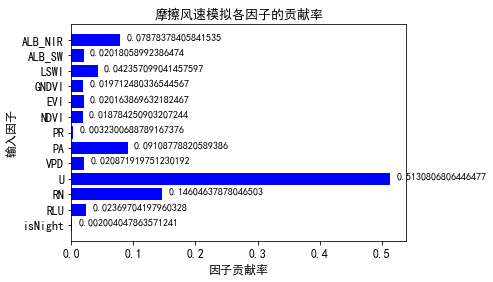

In [23]:
Calculate_contribution_rate(Decision_tree_model)

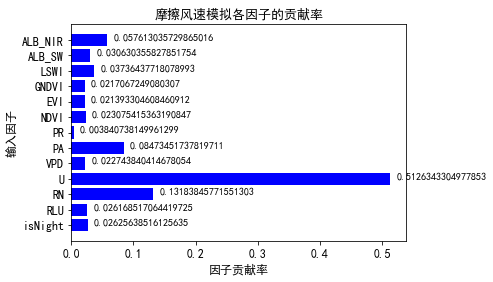

In [24]:
Calculate_contribution_rate(Random_forest_model)

In [ ]:
#数据分析可视化

array([[<AxesSubplot:title={'center':'isNight'}>,
        <AxesSubplot:title={'center':'TA'}>,
        <AxesSubplot:title={'center':'RG'}>,
        <AxesSubplot:title={'center':'RLU'}>],
       [<AxesSubplot:title={'center':'RN'}>,
        <AxesSubplot:title={'center':'U'}>,
        <AxesSubplot:title={'center':'VPD'}>,
        <AxesSubplot:title={'center':'PA'}>],
       [<AxesSubplot:title={'center':'PR'}>,
        <AxesSubplot:title={'center':'NDVI'}>,
        <AxesSubplot:title={'center':'EVI'}>,
        <AxesSubplot:title={'center':'GNDVI'}>],
       [<AxesSubplot:title={'center':'LSWI'}>,
        <AxesSubplot:title={'center':'ALB_SW'}>,
        <AxesSubplot:title={'center':'ALB_NIR'}>,
        <AxesSubplot:title={'center':'USTAR'}>],
       [<AxesSubplot:title={'center':'USTAR_QC'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

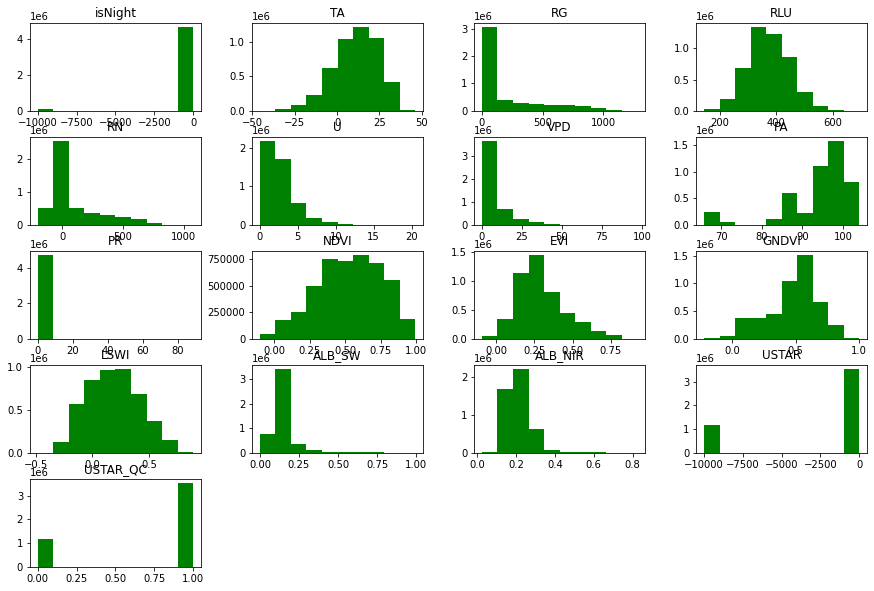

In [23]:
data.hist(bins=10, figsize=(15, 10),grid=False,color = "green")

In [26]:
data['isNight'].unique()
#有异常值

array([ 1.000e+00,  0.000e+00, -9.999e+03])